In [1]:
import numpy as np
import zipfile
import io
import glob
from PIL import Image

import tensorflow as tf
import matplotlib.pyplot as plt
import math
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def dataset_zip2imgarray(datadir, imgsize):
    with zipfile.ZipFile(datadir) as data:
        datalist = data.namelist()
        datasize = len(datalist)
        
        x = np.zeros((datasize, imgsize, imgsize, 3))
        nonelist=[]
        for i, fname in enumerate(datalist):
            if fname[-4:] == 'jpeg':
                try:
                    img = Image.open(
                        io.BytesIO(data.read(fname))).resize((imgsize, imgsize))
                    x[i] = np.asarray(img)
                except OSError:
                    nonelist.append(i)
            else:
                nonelist.append(i)
                
        xs = np.delete(x, nonelist, 0)
    return xs

## load data
datadir = ['data/images_part1.zip', 'data/images_part2.zip',
          'data/images_part3.zip']
imgsize=32
train_samples=None
for d in datadir:
    x = dataset_zip2imgarray(d, imgsize)/255.0
    if train_samples is None:
        train_samples = x
    else:
        train_samples = np.concatenate([train_samples, x], 0)

test_samples = dataset_zip2imgarray('data/images_part4.zip', imgsize)/255.0
        

In [3]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_random_seed(seed)

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

In [4]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 30
        self.batch_size = 32
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 128 ## 64 ==>32
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        
        self._dis_called = False
        self._gen_called = False

        self.tracked_noise = np.random.normal(0, 1, [16, self.code_size]) ## 64 => 16

        self.real_input = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size])
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, 32, 32, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, input):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            dis_conv1 = conv2d(input, 4, 2, 32, 'conv1')
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128])
            dis_fc4 = fc(dis_reshape3, 1, 'fc4')
            return dis_fc4

    def _generator(self, input):
        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            gen_fc1 = fc(input, 4 * 4 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4, 4, 128])
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2')
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3')
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4')
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        ################################################################################
        # Prob 2-1: complete the definition of these operations                        #
        ################################################################################
        
        # self.fake_samples_op = None
        self.fake_samples_op = self._generator(self.noise)
        
        # self.dis_loss_op = None
        #  E[L(D(x),1)] + E[L(G(z),0)]
        #self.dis_loss_op = self._loss(self.real_label, self._discriminator(self.real_input)) + self._loss(
        #    self.fake_label, self._discriminator(self.fake_samples_op))
        self.dis_loss_op = self._loss(self.real_label, 
                                      self._discriminator(self.real_input)
                                      ) + self._loss(self.fake_label,
            self._discriminator(self.fake_samples_op))
        
        # self.gen_loss_op = None
        self.gen_loss_op = self._loss(self.real_label,
                                      self._discriminator(self.fake_samples_op))
        
        ################################################################################
        # Prob 2-1: fix the definition of these operations                             #
        ################################################################################
        
        # dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        # self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op)
        dis_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "dis")
        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op,
                                                   var_list=dis_train_vars)
        
        # gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        # self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op)
        gen_train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                     "gen")
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op,
                                                  var_list=gen_train_vars)
        
        ################################################################################
        # Prob 2-4: check the definition of these operations                           #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        self.actmax_sample_op = self._generator(self.actmax_code)
        actmax_dis = self._discriminator(self.actmax_sample_op)
        self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

        actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        # Prob 2-4: complete the definition of these operations                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        # self.recon_loss_op = None
        self.recon_loss_op = self._reconstruction_loss(self.actmax_sample_op, self.recon_sample)
        
        # recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        
        # self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op)
        
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################

    # Training function
    def train(self, sess, train_samples):
        sess.run(tf.global_variables_initializer())

        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        max_steps = int(self.num_epoch * (num_train // self.batch_size))
        print('Start training ...')
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                # dis_feed_dict = {}
                dis_feed_dict = {self.real_input:batch_samples, self.real_label:zeros,
                                self.fake_label:ones, self.noise:noise, self.is_train:True}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                # gen_feed_dict = {}
                gen_feed_dict = {self.noise:noise, self.real_label:zeros,
                                 self.fake_label:ones, self.is_train:True}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))

            fig = plt.figure(figsize = (8, 8))   
            ax1 = plt.subplot(111)
            ax1.imshow(viz_grid(self.generate(self.tracked_noise), 1))
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
        print('... Done!')

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        
        ################################################################################
        # Prob 2-4: initialize self.actmax_code                                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        # actmax_init_val = None
        ## sample <class 'numpy.ndarray'> (1, 32, 32, 3)
        #sample_tf = tf.convert_to_tensor(sample, dtype = tf.float32)
        #act_ini_run = sess.run(self._discriminator(sample_tf), feed_dict={self.is_train:False})
        #act_ini_run = tf.get_default_graph().get_tensor_by_name("conv3:0")
        #act_ini_bn = batch_norm(act_ini_run, False)
        #act_ini_lrelu = leaky_relu(act_ini_bn)
        #act_ini_reshape = tf.reshape(act_ini_lrelu, [-1, 4 * 4 * 128])
        #actmax_init_val = act_ini_reshape
        
        
        #sample_tf = tf.convert_to_tensor(sample, dtype = tf.float32)
        #actmax_init_val = self._discriminator(sample_tf)
        #actmax_init_val = sample_tf
        #actmax_init_val = self.tracked_noise
        actmax_init_val = np.random.normal(0, 1, [1, self.code_size])
        
        #print('act_ini', actmax_init_val, actmax_init_val.shape)
        
        #actmax_init_val = self.generate_one_sample(sample)
       
        
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ################################################################################
            # Prob 2-4: complete the feed dictionary                                       #
            # skip this part when working on problem 2-1 and come back for problem 2-4     #
            ################################################################################   
            
            # recon_feed_dict = {}
            recon_feed_dict = {self.recon_sample: sample, self.actmax_label: np.ones([1, 1]),
                               self.is_train: True}
            
            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code):
        
        ################################################################################
        # Prob 2-1: complete the feed dictionary                                       #
        ################################################################################
        
        # gen_vis_feed_dict = {}
        gen_vis_feed_dict = {self.noise:code, self.is_train:False}
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes):
        generated = np.zeros((codes.shape[0], 32, 32, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1])
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ################################################################################
        # Prob 2-4: check this function                                                #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)

Start training ...
Iteration 50/10320: dis loss = 0.3562, gen loss = 2.3605
Iteration 100/10320: dis loss = 0.0643, gen loss = 4.1143
Iteration 150/10320: dis loss = 0.0183, gen loss = 5.0416
Iteration 200/10320: dis loss = 0.0392, gen loss = 4.2369
Iteration 250/10320: dis loss = 0.0579, gen loss = 4.8944
Iteration 300/10320: dis loss = 0.0322, gen loss = 4.6488


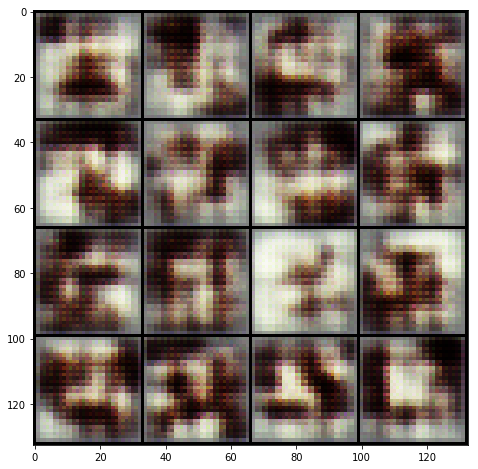

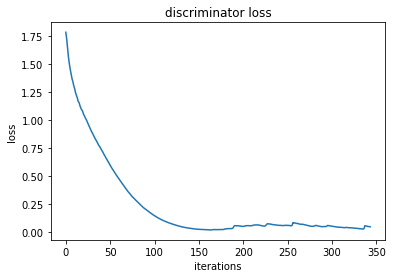

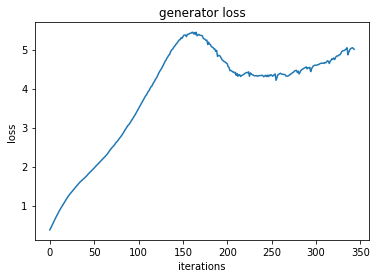

Iteration 350/10320: dis loss = 0.0450, gen loss = 4.2534
Iteration 400/10320: dis loss = 0.0619, gen loss = 4.6080
Iteration 450/10320: dis loss = 0.0820, gen loss = 3.8105
Iteration 500/10320: dis loss = 0.6438, gen loss = 5.2335
Iteration 550/10320: dis loss = 0.0445, gen loss = 4.1182
Iteration 600/10320: dis loss = 0.3227, gen loss = 1.2378
Iteration 650/10320: dis loss = 0.0457, gen loss = 4.0119


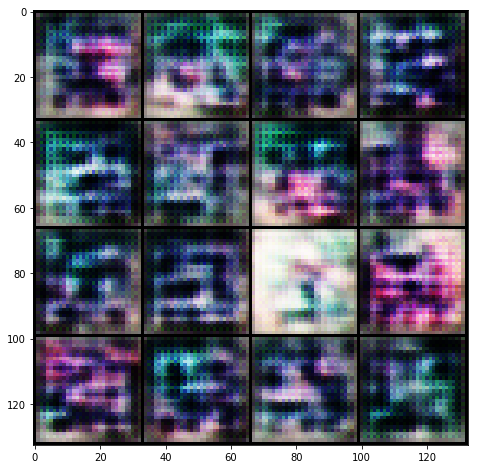

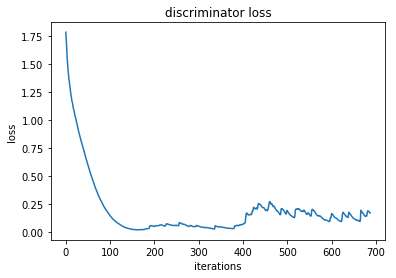

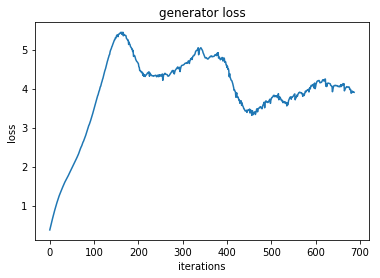

Iteration 700/10320: dis loss = 0.1152, gen loss = 3.6259
Iteration 750/10320: dis loss = 0.3301, gen loss = 0.7585
Iteration 800/10320: dis loss = 0.0625, gen loss = 4.6902
Iteration 850/10320: dis loss = 0.0381, gen loss = 4.2294
Iteration 900/10320: dis loss = 0.9284, gen loss = 4.9239
Iteration 950/10320: dis loss = 0.0572, gen loss = 4.5657
Iteration 1000/10320: dis loss = 0.3280, gen loss = 1.7933


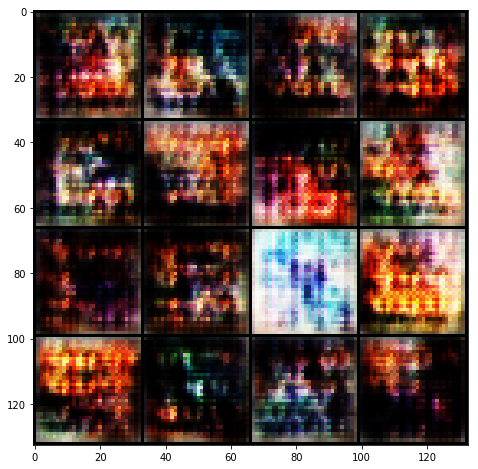

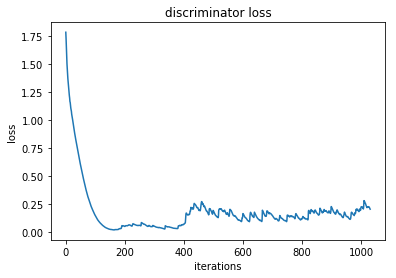

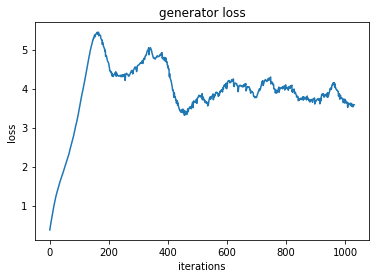

Iteration 1050/10320: dis loss = 0.0720, gen loss = 4.1382
Iteration 1100/10320: dis loss = 0.0878, gen loss = 3.8510
Iteration 1150/10320: dis loss = 0.1631, gen loss = 3.4344
Iteration 1200/10320: dis loss = 0.1072, gen loss = 3.5798
Iteration 1250/10320: dis loss = 0.0681, gen loss = 3.8552
Iteration 1300/10320: dis loss = 0.0538, gen loss = 4.2780
Iteration 1350/10320: dis loss = 0.0891, gen loss = 5.2987


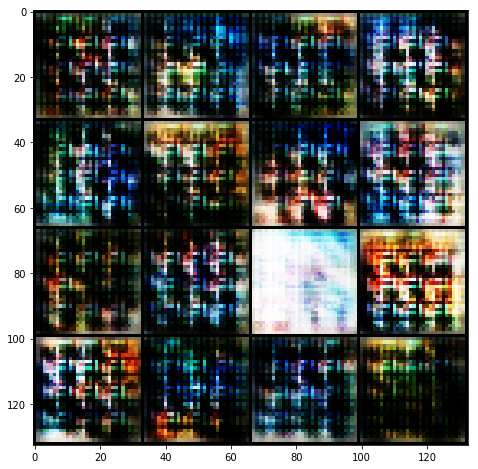

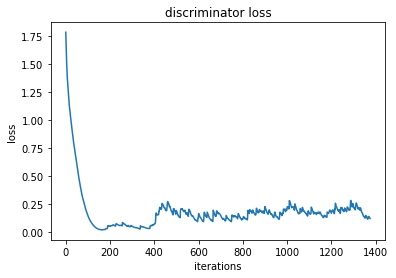

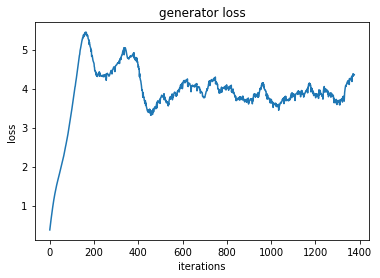

Iteration 1400/10320: dis loss = 0.3077, gen loss = 4.7496
Iteration 1450/10320: dis loss = 0.4763, gen loss = 2.2867
Iteration 1500/10320: dis loss = 0.1357, gen loss = 3.8852
Iteration 1550/10320: dis loss = 0.2961, gen loss = 3.2381
Iteration 1600/10320: dis loss = 0.0442, gen loss = 4.1390
Iteration 1650/10320: dis loss = 0.4079, gen loss = 5.4336
Iteration 1700/10320: dis loss = 0.5620, gen loss = 1.5413


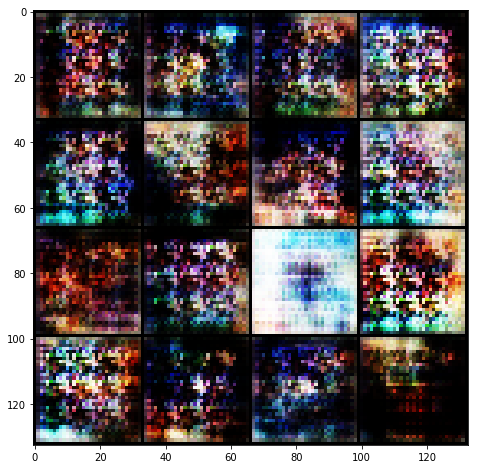

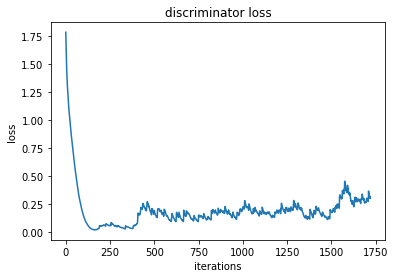

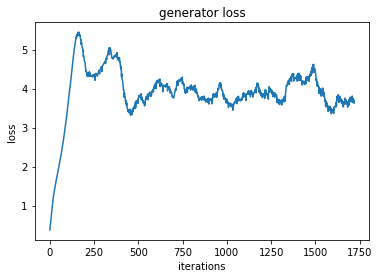

Iteration 1750/10320: dis loss = 0.0735, gen loss = 4.1949
Iteration 1800/10320: dis loss = 0.4509, gen loss = 5.0537
Iteration 1850/10320: dis loss = 0.8600, gen loss = 1.3368
Iteration 1900/10320: dis loss = 0.4297, gen loss = 2.6453
Iteration 1950/10320: dis loss = 0.2095, gen loss = 2.9380
Iteration 2000/10320: dis loss = 0.5364, gen loss = 2.3213
Iteration 2050/10320: dis loss = 0.3535, gen loss = 3.1440


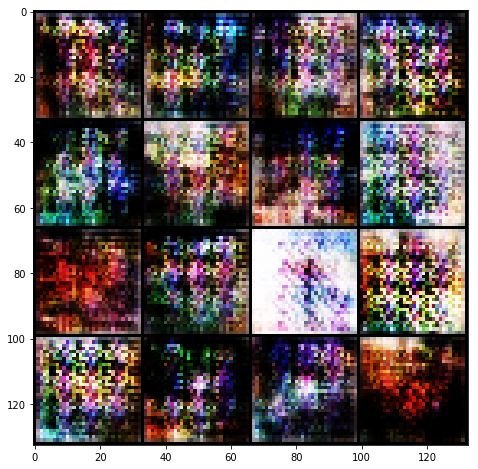

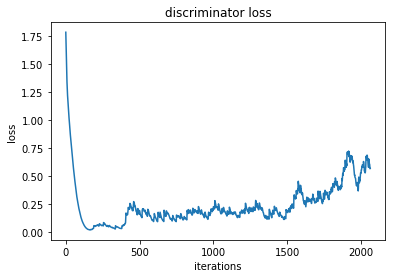

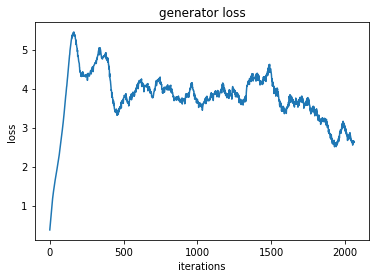

Iteration 2100/10320: dis loss = 0.8698, gen loss = 0.9519
Iteration 2150/10320: dis loss = 0.4699, gen loss = 2.5638
Iteration 2200/10320: dis loss = 0.5054, gen loss = 1.8645
Iteration 2250/10320: dis loss = 1.4624, gen loss = 0.2597
Iteration 2300/10320: dis loss = 0.2894, gen loss = 2.6040
Iteration 2350/10320: dis loss = 0.3839, gen loss = 2.3411
Iteration 2400/10320: dis loss = 0.6493, gen loss = 1.6526


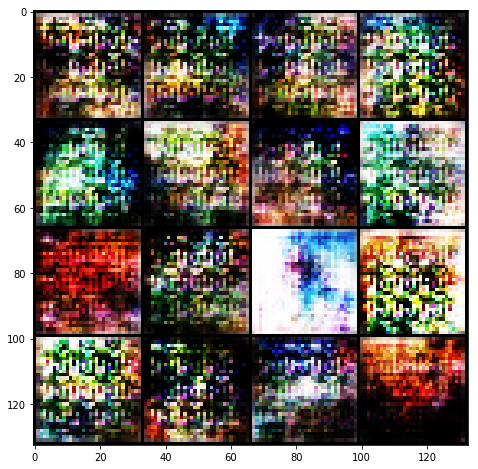

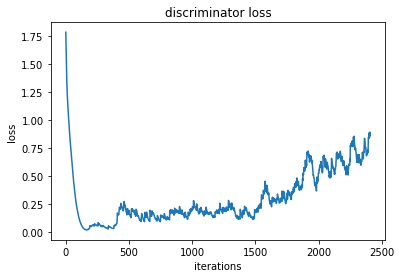

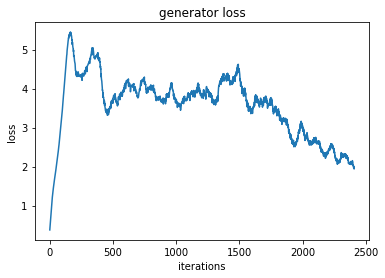

Iteration 2450/10320: dis loss = 0.7658, gen loss = 2.4179
Iteration 2500/10320: dis loss = 0.9680, gen loss = 0.8801
Iteration 2550/10320: dis loss = 0.7953, gen loss = 1.3962
Iteration 2600/10320: dis loss = 1.2107, gen loss = 1.6349
Iteration 2650/10320: dis loss = 1.0736, gen loss = 1.7508
Iteration 2700/10320: dis loss = 1.3574, gen loss = 2.6214
Iteration 2750/10320: dis loss = 0.7484, gen loss = 1.9141


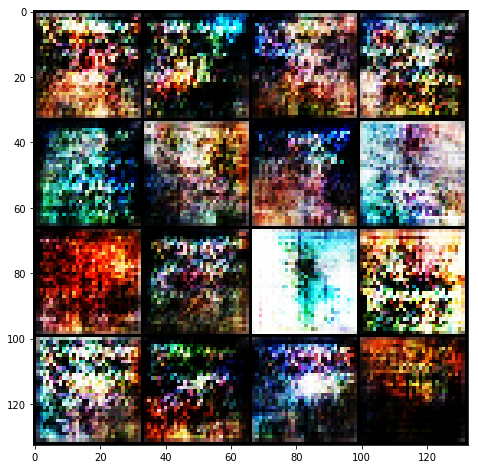

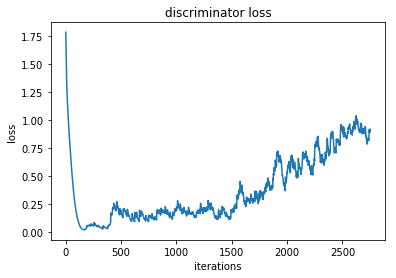

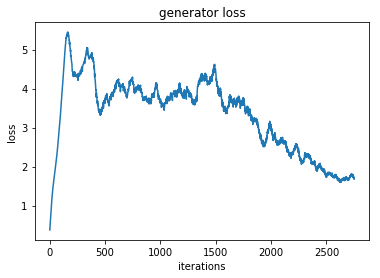

Iteration 2800/10320: dis loss = 0.9323, gen loss = 1.5300
Iteration 2850/10320: dis loss = 0.9066, gen loss = 2.5063
Iteration 2900/10320: dis loss = 0.8162, gen loss = 1.4010
Iteration 2950/10320: dis loss = 0.7467, gen loss = 1.4149
Iteration 3000/10320: dis loss = 0.7926, gen loss = 1.6382
Iteration 3050/10320: dis loss = 1.0849, gen loss = 1.9121


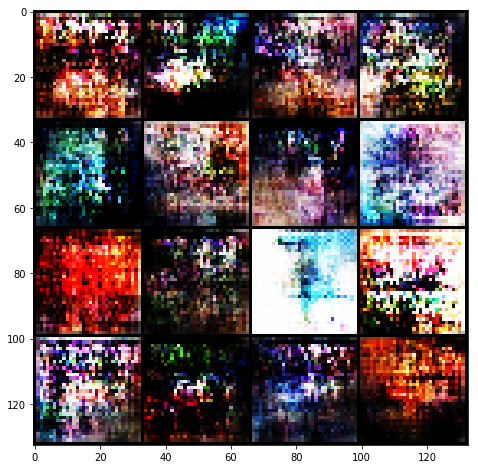

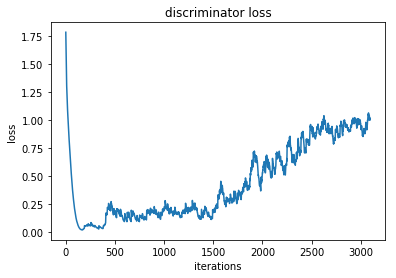

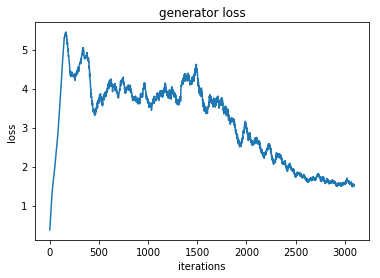

Iteration 3100/10320: dis loss = 0.9258, gen loss = 1.3928
Iteration 3150/10320: dis loss = 1.0388, gen loss = 0.9939
Iteration 3200/10320: dis loss = 0.7573, gen loss = 2.4562
Iteration 3250/10320: dis loss = 0.9513, gen loss = 1.1858
Iteration 3300/10320: dis loss = 1.0523, gen loss = 1.4229
Iteration 3350/10320: dis loss = 0.8817, gen loss = 1.5552
Iteration 3400/10320: dis loss = 1.0433, gen loss = 1.4003


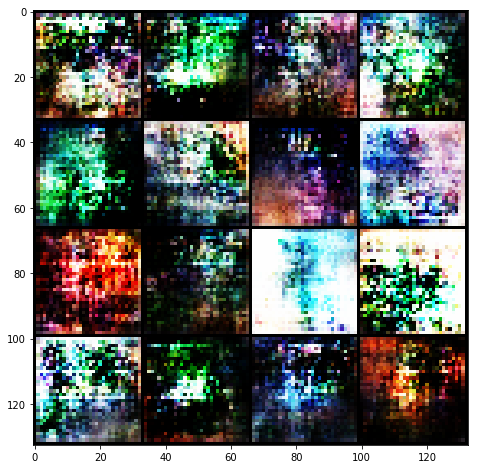

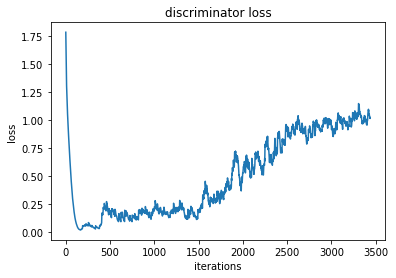

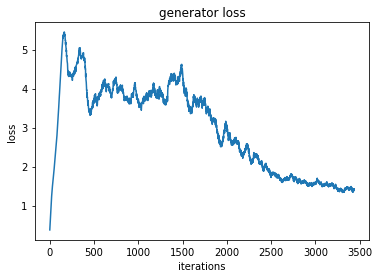

Iteration 3450/10320: dis loss = 0.9710, gen loss = 1.3108
Iteration 3500/10320: dis loss = 0.6394, gen loss = 1.4181
Iteration 3550/10320: dis loss = 0.7918, gen loss = 1.7070
Iteration 3600/10320: dis loss = 0.9009, gen loss = 1.4991
Iteration 3650/10320: dis loss = 1.2210, gen loss = 1.2440
Iteration 3700/10320: dis loss = 0.7755, gen loss = 1.5947
Iteration 3750/10320: dis loss = 1.1373, gen loss = 0.6266


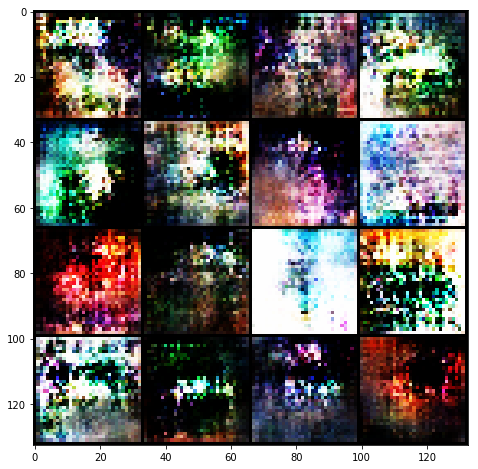

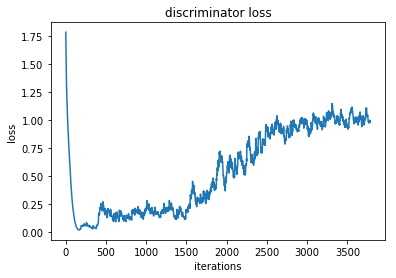

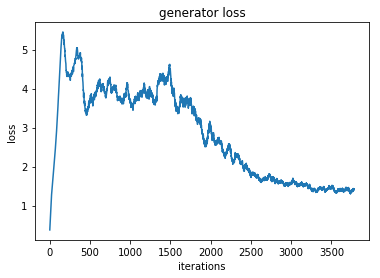

Iteration 3800/10320: dis loss = 0.8729, gen loss = 1.3165
Iteration 3850/10320: dis loss = 0.9305, gen loss = 1.0027
Iteration 3900/10320: dis loss = 1.2612, gen loss = 1.8940
Iteration 3950/10320: dis loss = 0.8106, gen loss = 1.0897
Iteration 4000/10320: dis loss = 0.9658, gen loss = 0.9369
Iteration 4050/10320: dis loss = 1.0454, gen loss = 0.7908
Iteration 4100/10320: dis loss = 1.0998, gen loss = 0.7569


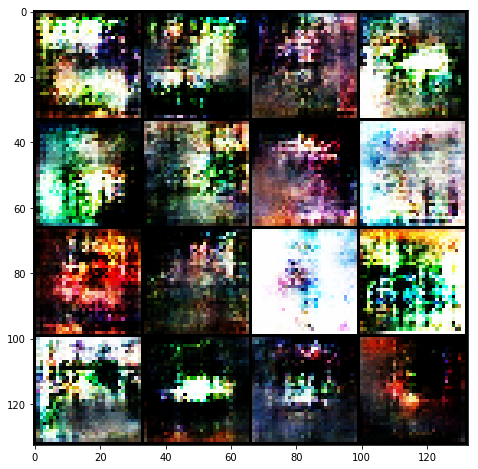

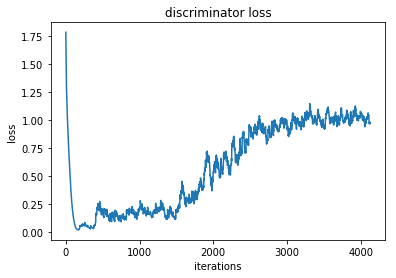

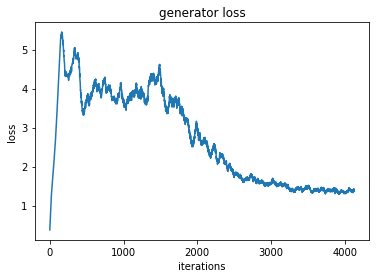

Iteration 4150/10320: dis loss = 1.3942, gen loss = 1.0416
Iteration 4200/10320: dis loss = 0.9755, gen loss = 1.7316
Iteration 4250/10320: dis loss = 0.7835, gen loss = 1.1901
Iteration 4300/10320: dis loss = 1.0235, gen loss = 2.0362
Iteration 4350/10320: dis loss = 1.1551, gen loss = 0.5651
Iteration 4400/10320: dis loss = 0.9840, gen loss = 1.3580
Iteration 4450/10320: dis loss = 0.9846, gen loss = 1.4016


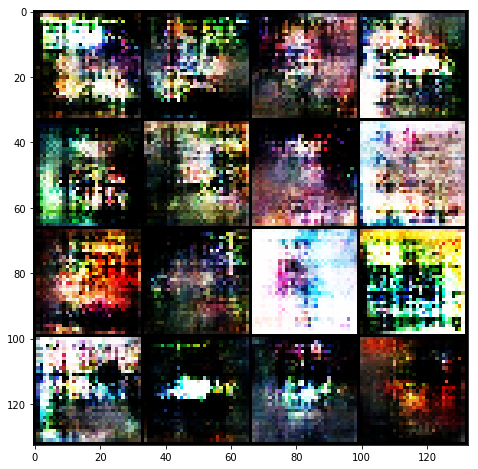

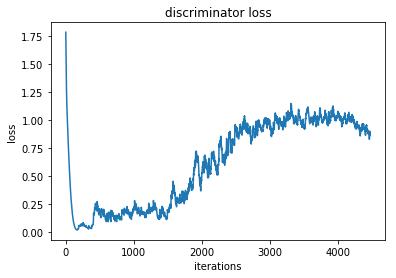

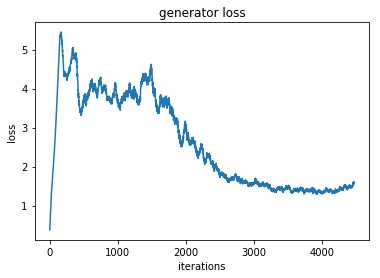

Iteration 4500/10320: dis loss = 1.1794, gen loss = 0.7234
Iteration 4550/10320: dis loss = 1.0414, gen loss = 2.2286
Iteration 4600/10320: dis loss = 0.7941, gen loss = 1.1406
Iteration 4650/10320: dis loss = 0.7654, gen loss = 2.0956
Iteration 4700/10320: dis loss = 1.2546, gen loss = 0.8678
Iteration 4750/10320: dis loss = 1.3048, gen loss = 0.7710
Iteration 4800/10320: dis loss = 0.5603, gen loss = 1.9692


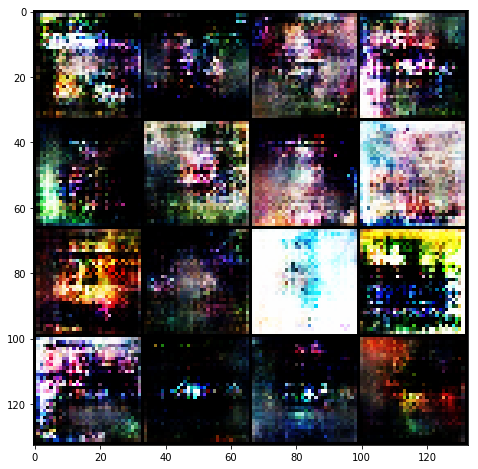

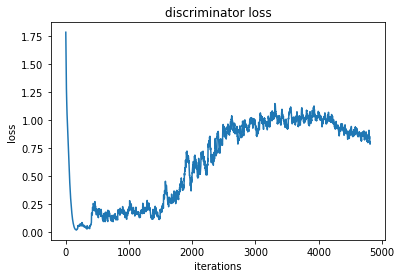

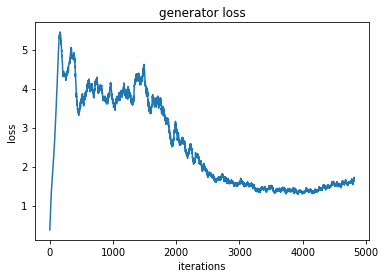

Iteration 4850/10320: dis loss = 0.6835, gen loss = 1.6445
Iteration 4900/10320: dis loss = 0.8561, gen loss = 1.4547
Iteration 4950/10320: dis loss = 0.4884, gen loss = 1.8242
Iteration 5000/10320: dis loss = 0.7706, gen loss = 1.5325
Iteration 5050/10320: dis loss = 0.8516, gen loss = 1.2573
Iteration 5100/10320: dis loss = 0.6801, gen loss = 1.3195
Iteration 5150/10320: dis loss = 1.4063, gen loss = 0.6377


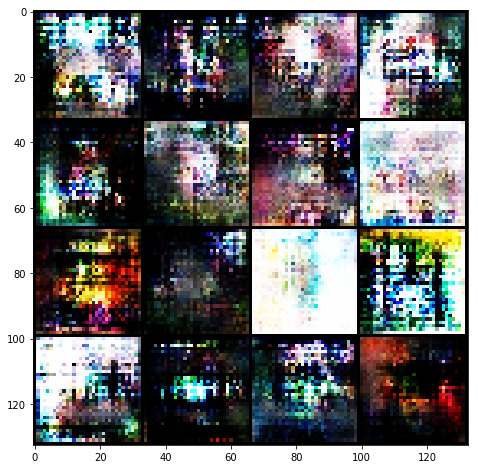

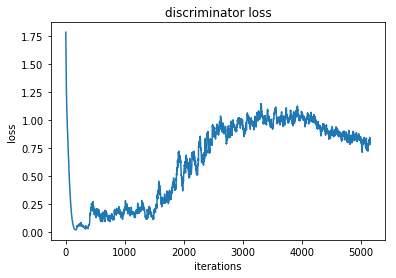

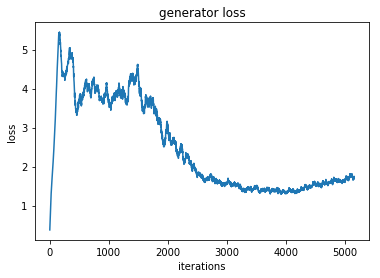

Iteration 5200/10320: dis loss = 1.0688, gen loss = 0.8486
Iteration 5250/10320: dis loss = 0.7786, gen loss = 2.0820
Iteration 5300/10320: dis loss = 1.0861, gen loss = 0.9411
Iteration 5350/10320: dis loss = 0.2948, gen loss = 2.4758
Iteration 5400/10320: dis loss = 0.7903, gen loss = 1.4360
Iteration 5450/10320: dis loss = 0.5130, gen loss = 3.0266
Iteration 5500/10320: dis loss = 0.7361, gen loss = 1.6463


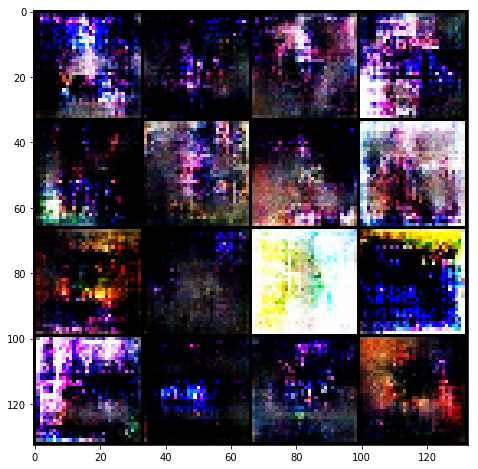

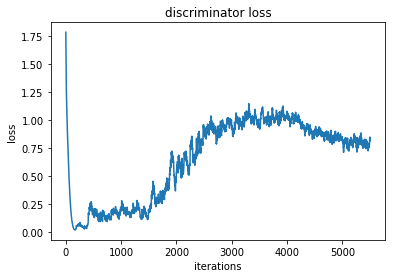

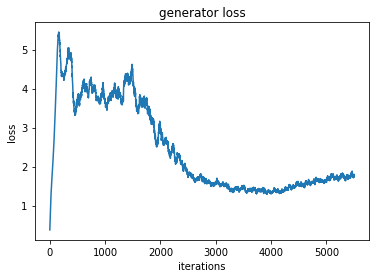

Iteration 5550/10320: dis loss = 1.1240, gen loss = 2.0660
Iteration 5600/10320: dis loss = 0.8964, gen loss = 2.0946
Iteration 5650/10320: dis loss = 0.6243, gen loss = 1.3859
Iteration 5700/10320: dis loss = 0.8196, gen loss = 1.4451
Iteration 5750/10320: dis loss = 0.5985, gen loss = 2.6745
Iteration 5800/10320: dis loss = 0.4005, gen loss = 2.1059


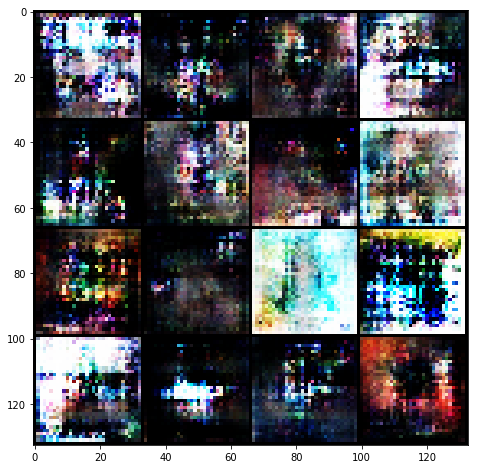

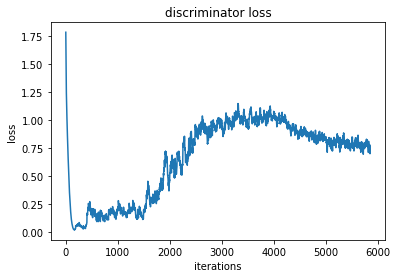

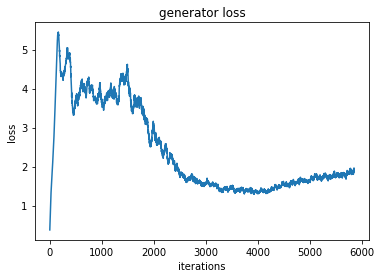

Iteration 5850/10320: dis loss = 1.1680, gen loss = 1.4774
Iteration 5900/10320: dis loss = 0.7652, gen loss = 2.1984
Iteration 5950/10320: dis loss = 0.8692, gen loss = 1.9096
Iteration 6000/10320: dis loss = 0.5931, gen loss = 1.6426
Iteration 6050/10320: dis loss = 0.8555, gen loss = 2.7505
Iteration 6100/10320: dis loss = 0.4802, gen loss = 1.7776
Iteration 6150/10320: dis loss = 0.7222, gen loss = 1.7689


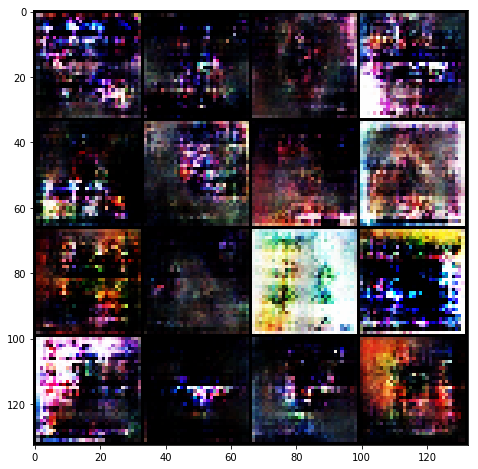

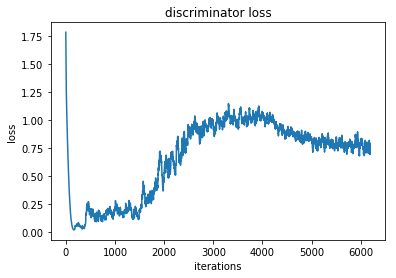

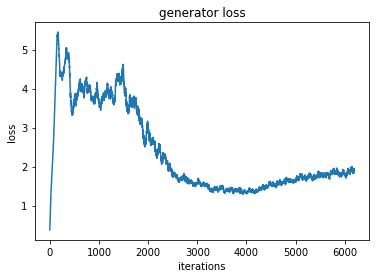

Iteration 6200/10320: dis loss = 0.5605, gen loss = 2.3358
Iteration 6250/10320: dis loss = 0.6196, gen loss = 2.1936
Iteration 6300/10320: dis loss = 0.4519, gen loss = 3.0816
Iteration 6350/10320: dis loss = 0.6227, gen loss = 2.7248
Iteration 6400/10320: dis loss = 0.7002, gen loss = 2.9110
Iteration 6450/10320: dis loss = 0.8155, gen loss = 1.3454
Iteration 6500/10320: dis loss = 0.8538, gen loss = 3.2286


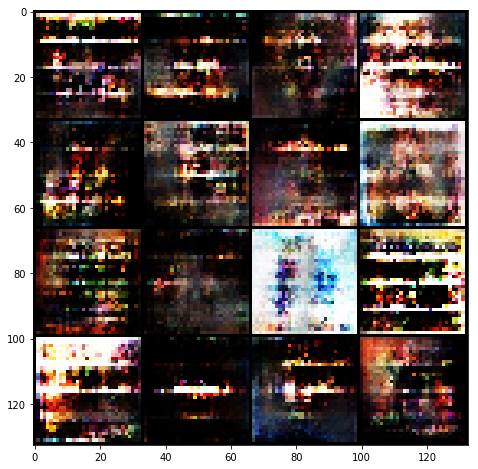

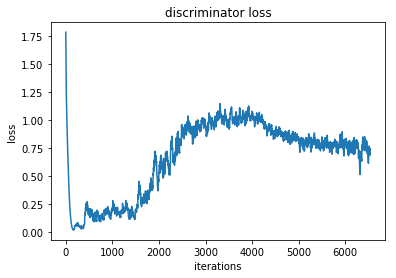

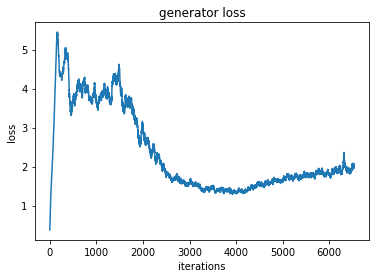

Iteration 6550/10320: dis loss = 1.3638, gen loss = 2.3133
Iteration 6600/10320: dis loss = 0.5284, gen loss = 2.2752
Iteration 6650/10320: dis loss = 0.6163, gen loss = 2.1073
Iteration 6700/10320: dis loss = 1.3018, gen loss = 1.0627
Iteration 6750/10320: dis loss = 1.3322, gen loss = 1.1641
Iteration 6800/10320: dis loss = 0.4660, gen loss = 1.8809
Iteration 6850/10320: dis loss = 0.6334, gen loss = 1.5839


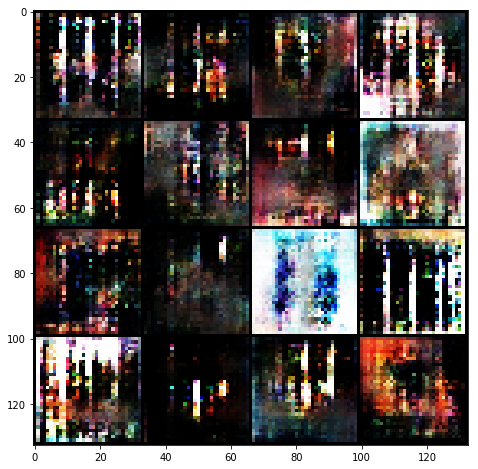

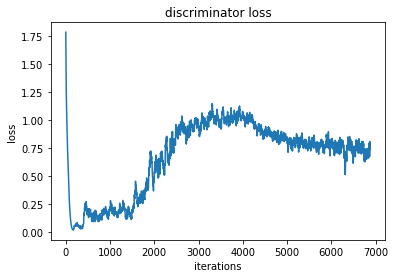

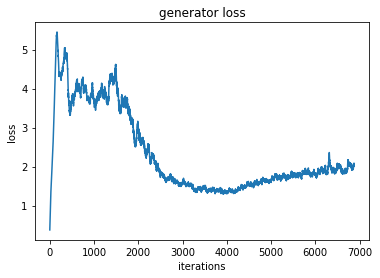

Iteration 6900/10320: dis loss = 0.5140, gen loss = 1.9280
Iteration 6950/10320: dis loss = 0.5230, gen loss = 2.5925
Iteration 7000/10320: dis loss = 1.2422, gen loss = 1.2263
Iteration 7050/10320: dis loss = 0.7037, gen loss = 2.5207
Iteration 7100/10320: dis loss = 1.0817, gen loss = 0.8797
Iteration 7150/10320: dis loss = 0.4515, gen loss = 2.8165
Iteration 7200/10320: dis loss = 0.6476, gen loss = 1.5343


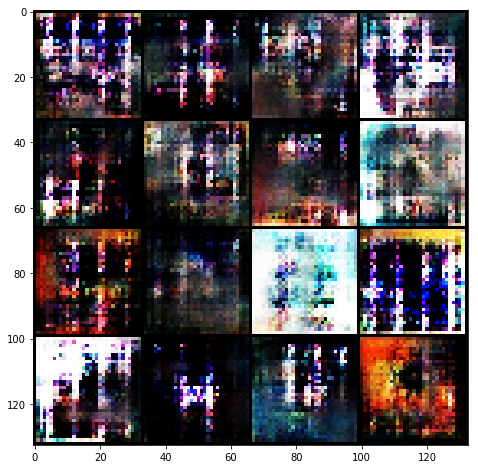

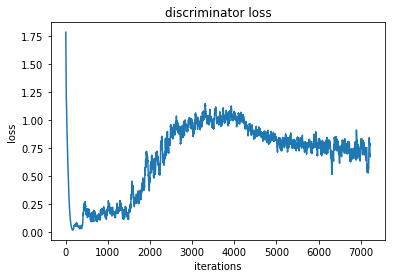

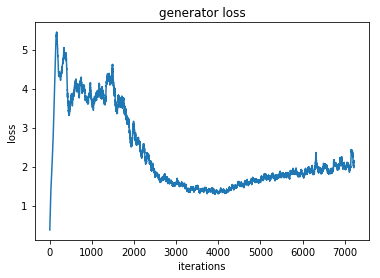

Iteration 7250/10320: dis loss = 0.9519, gen loss = 2.2979
Iteration 7300/10320: dis loss = 0.3846, gen loss = 2.2448
Iteration 7350/10320: dis loss = 0.9248, gen loss = 1.1855
Iteration 7400/10320: dis loss = 0.4557, gen loss = 1.8714
Iteration 7450/10320: dis loss = 0.8250, gen loss = 1.5348
Iteration 7500/10320: dis loss = 0.9379, gen loss = 0.8459
Iteration 7550/10320: dis loss = 0.2979, gen loss = 2.4584


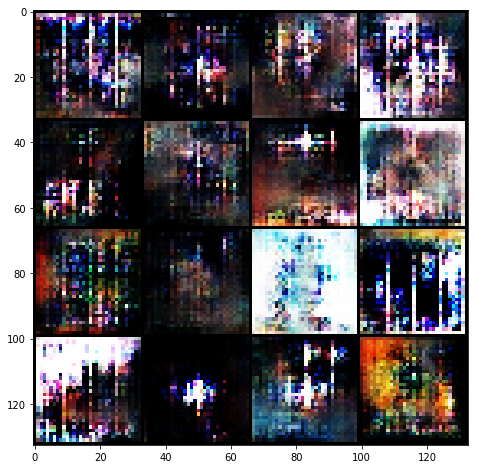

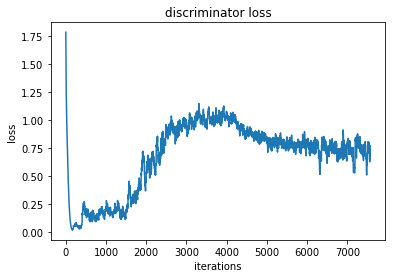

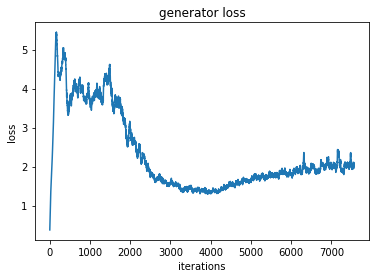

Iteration 7600/10320: dis loss = 0.8606, gen loss = 2.9747
Iteration 7650/10320: dis loss = 0.5731, gen loss = 2.4905
Iteration 7700/10320: dis loss = 1.1135, gen loss = 1.0267
Iteration 7750/10320: dis loss = 0.5815, gen loss = 2.6490
Iteration 7800/10320: dis loss = 0.8554, gen loss = 1.0136
Iteration 7850/10320: dis loss = 0.6933, gen loss = 1.0709
Iteration 7900/10320: dis loss = 0.4475, gen loss = 1.7464


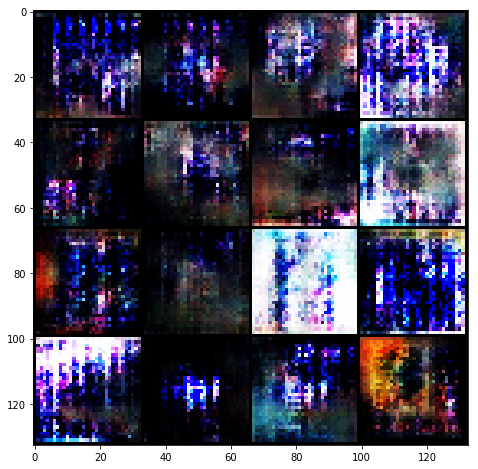

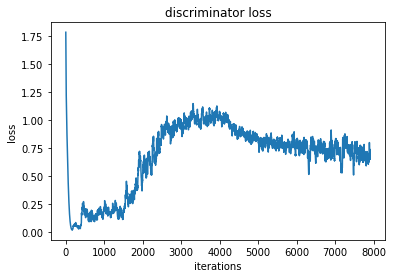

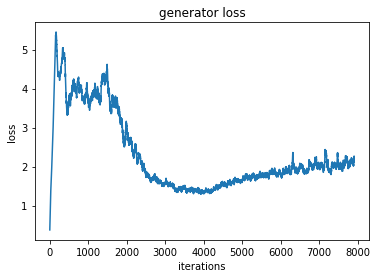

Iteration 7950/10320: dis loss = 0.7366, gen loss = 0.9452
Iteration 8000/10320: dis loss = 0.9111, gen loss = 1.5533
Iteration 8050/10320: dis loss = 0.7818, gen loss = 1.9074
Iteration 8100/10320: dis loss = 0.3878, gen loss = 2.3801
Iteration 8150/10320: dis loss = 0.8036, gen loss = 0.7089
Iteration 8200/10320: dis loss = 0.6694, gen loss = 2.0952
Iteration 8250/10320: dis loss = 0.7307, gen loss = 1.8128


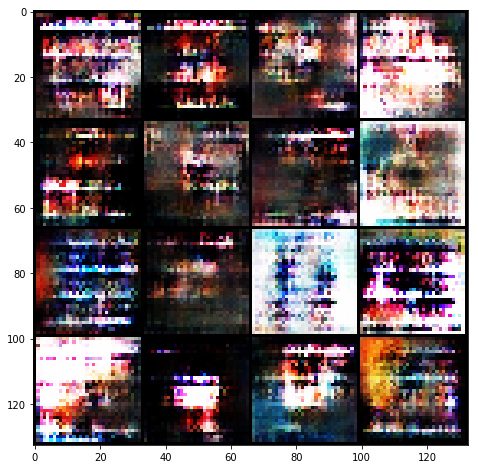

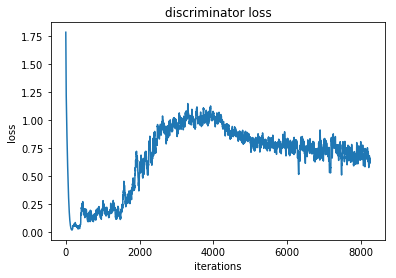

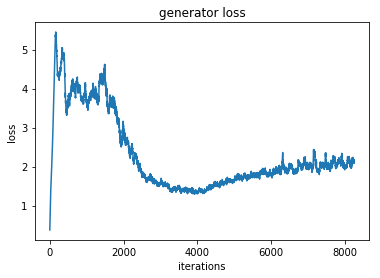

Iteration 8300/10320: dis loss = 0.7337, gen loss = 1.3489
Iteration 8350/10320: dis loss = 0.3916, gen loss = 2.6833
Iteration 8400/10320: dis loss = 0.8611, gen loss = 1.1027
Iteration 8450/10320: dis loss = 0.7515, gen loss = 2.3044
Iteration 8500/10320: dis loss = 0.6967, gen loss = 1.3581
Iteration 8550/10320: dis loss = 0.3821, gen loss = 2.7981
Iteration 8600/10320: dis loss = 0.8925, gen loss = 1.3112


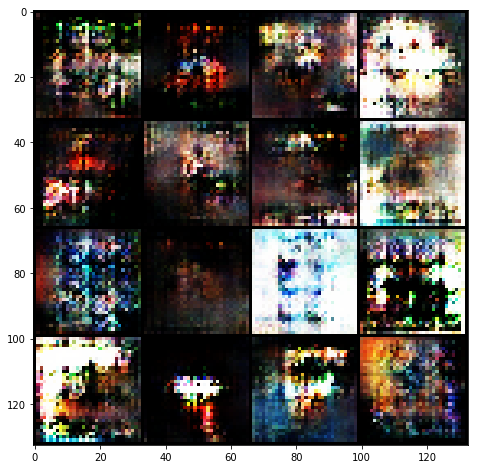

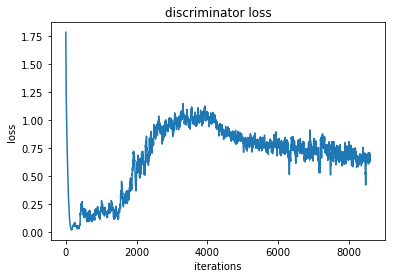

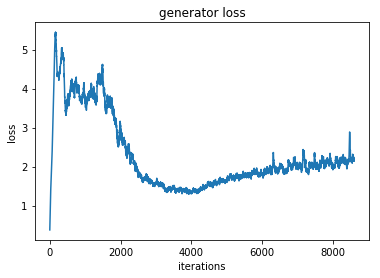

Iteration 8650/10320: dis loss = 0.5652, gen loss = 1.9935
Iteration 8700/10320: dis loss = 0.2170, gen loss = 2.7944
Iteration 8750/10320: dis loss = 0.6930, gen loss = 1.1611
Iteration 8800/10320: dis loss = 0.6109, gen loss = 3.0953
Iteration 8850/10320: dis loss = 0.2693, gen loss = 2.8157
Iteration 8900/10320: dis loss = 0.3830, gen loss = 3.8307


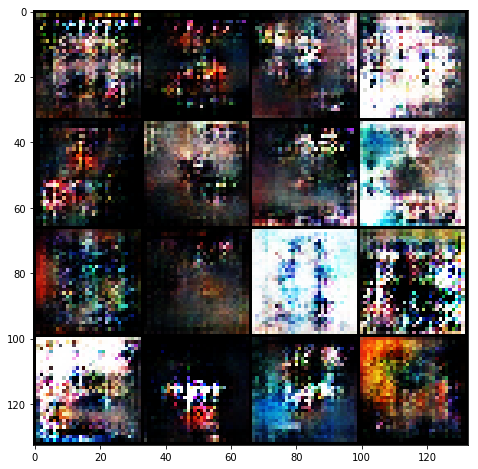

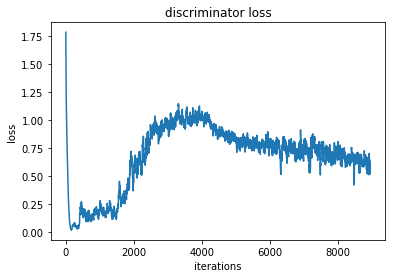

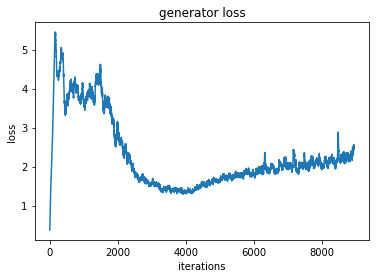

Iteration 8950/10320: dis loss = 0.4508, gen loss = 1.8222
Iteration 9000/10320: dis loss = 0.8871, gen loss = 1.9317
Iteration 9050/10320: dis loss = 0.7030, gen loss = 0.7634
Iteration 9100/10320: dis loss = 0.3253, gen loss = 2.3567
Iteration 9150/10320: dis loss = 0.6259, gen loss = 2.7331
Iteration 9200/10320: dis loss = 0.6114, gen loss = 1.5317
Iteration 9250/10320: dis loss = 0.3349, gen loss = 2.5693


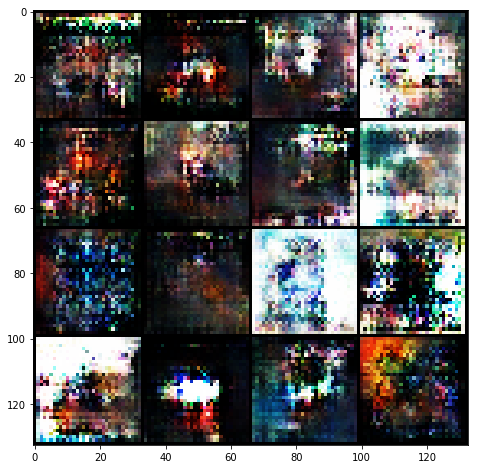

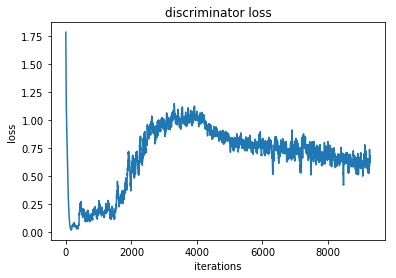

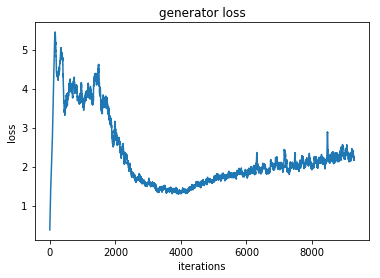

Iteration 9300/10320: dis loss = 0.5743, gen loss = 2.5945
Iteration 9350/10320: dis loss = 0.3552, gen loss = 1.9635
Iteration 9400/10320: dis loss = 0.9620, gen loss = 4.8379
Iteration 9450/10320: dis loss = 0.6172, gen loss = 2.3786
Iteration 9500/10320: dis loss = 0.3571, gen loss = 2.8069
Iteration 9550/10320: dis loss = 0.6221, gen loss = 4.5444
Iteration 9600/10320: dis loss = 0.6439, gen loss = 1.4025


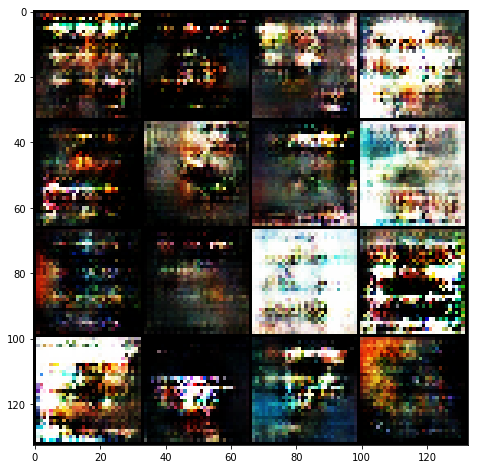

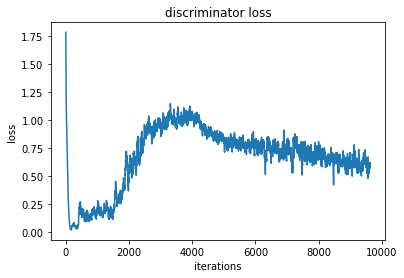

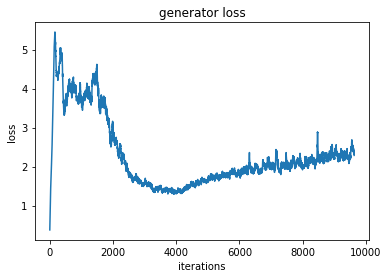

Iteration 9650/10320: dis loss = 0.4441, gen loss = 2.0992
Iteration 9700/10320: dis loss = 0.5184, gen loss = 2.8268
Iteration 9750/10320: dis loss = 0.3530, gen loss = 3.2193
Iteration 9800/10320: dis loss = 0.3350, gen loss = 2.2520
Iteration 9850/10320: dis loss = 1.2779, gen loss = 0.3914
Iteration 9900/10320: dis loss = 0.3921, gen loss = 2.2156
Iteration 9950/10320: dis loss = 0.9630, gen loss = 3.7812


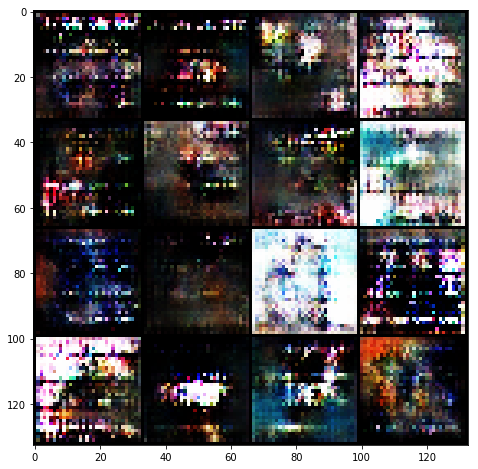

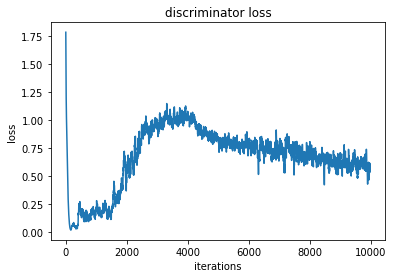

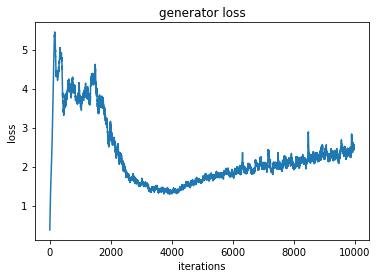

Iteration 10000/10320: dis loss = 0.4912, gen loss = 2.9054
Iteration 10050/10320: dis loss = 0.7362, gen loss = 0.7912
Iteration 10100/10320: dis loss = 0.6762, gen loss = 1.5987
Iteration 10150/10320: dis loss = 0.8900, gen loss = 0.8933
Iteration 10200/10320: dis loss = 0.3834, gen loss = 2.3772
Iteration 10250/10320: dis loss = 0.4157, gen loss = 1.9543
Iteration 10300/10320: dis loss = 0.4031, gen loss = 2.1960


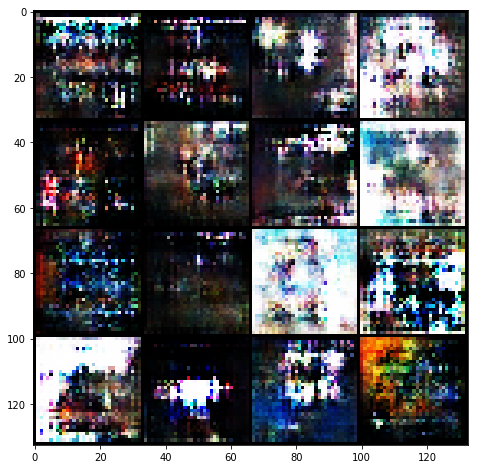

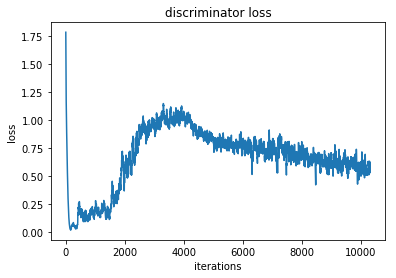

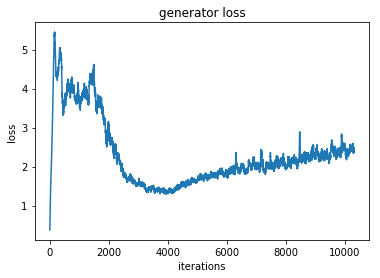

... Done!


In [5]:
tf.reset_default_graph()
set_seed(21)

with tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True,log_device_placement=True)) as sess:
    with tf.device('/gpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dcgan.train(sess, train_samples)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model/dcgan')


INFO:tensorflow:Restoring parameters from model/dcgan


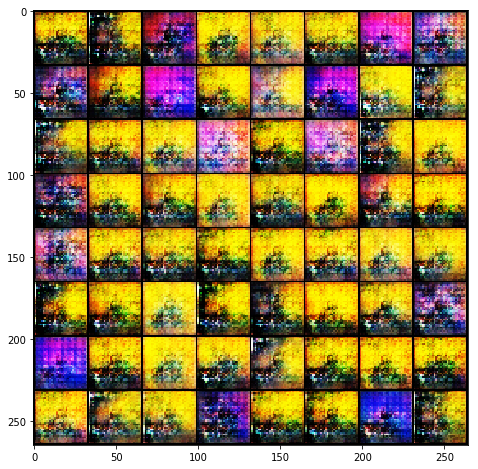

In [6]:
tf.reset_default_graph()
set_seed(241)

with tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True,log_device_placement=True)) as sess:
    with tf.device('/gpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')
        actmax_results = dcgan.actmax(np.random.random([64, dcgan.code_size]))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(actmax_results, 1))
        plt.show()

INFO:tensorflow:Restoring parameters from model/dcgan
average reconstruction loss = 11.0980


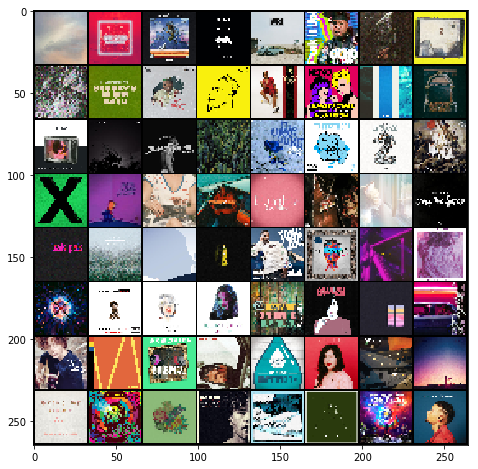

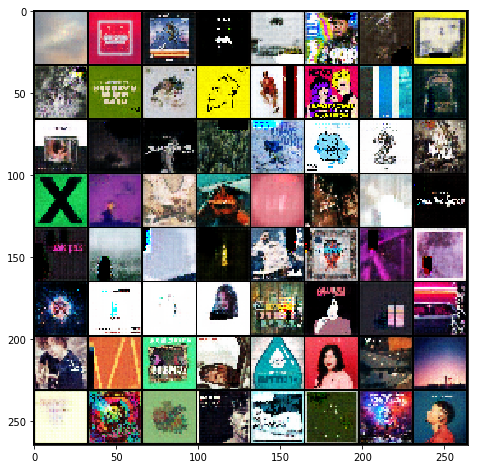

In [7]:
tf.reset_default_graph()

with tf.Session(config=tf.ConfigProto(
        allow_soft_placement=True,log_device_placement=True)) as sess:
    with tf.device('/gpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')

        avg_loss, reconstructions = dcgan.reconstruct(test_samples[0:64])
        print('average reconstruction loss = {0:.4f}'.format(avg_loss))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(test_samples[0:64], 1))
        plt.show()
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(reconstructions, 1))
        plt.show()